Epoch 1/5 Training:  82%|████████▏ | 490/601 [03:04<00:41,  2.66it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5  Loss: 0.6837  Train Acc: 0.6605  Val Acc: 0.6713


Epoch 2/5  Loss: 0.6702  Train Acc: 0.6609  Val Acc: 0.6713


Epoch 3/5  Loss: 0.6591  Train Acc: 0.6609  Val Acc: 0.6713


Epoch 4/5  Loss: 0.6504  Train Acc: 0.6609  Val Acc: 0.6713


Epoch 5/5  Loss: 0.6453  Train Acc: 0.6609  Val Acc: 0.6713


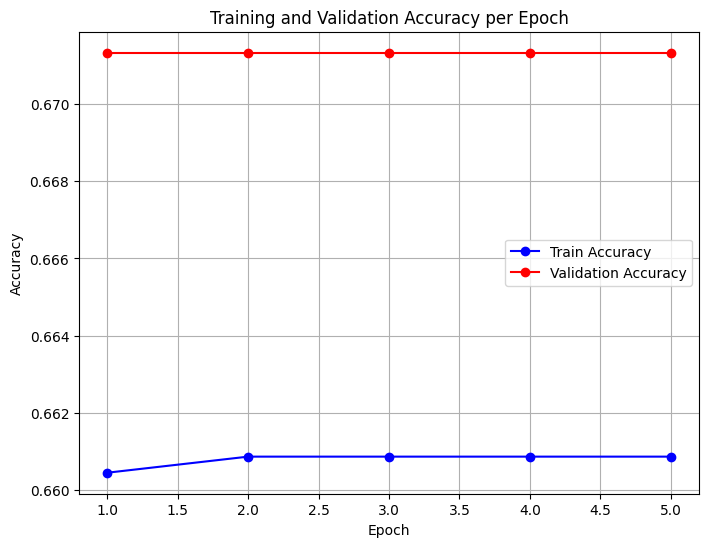

Extracting features for TSNE: 100%|██████████| 99/99 [00:35<00:00,  2.79it/s]


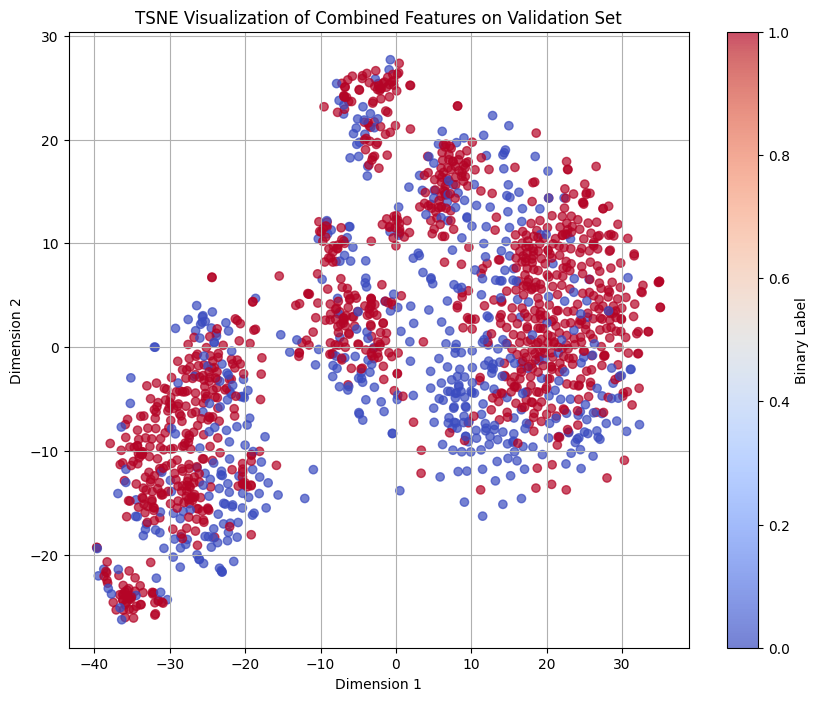

: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModel
from tqdm import tqdm  # For progress bars
from sklearn.manifold import TSNE  # For TSNE visualization

# --- Load & Filter Data ---
train_data = pd.read_csv(
    'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv',
    sep='\t'
)
dev_data = pd.read_csv(
    'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv',
    sep='\t'
)

train_data = train_data[train_data['label_text_image'] == 'Positive'].reset_index(drop=True)
dev_data   = dev_data[dev_data['label_text_image'] == 'Positive'].reset_index(drop=True)
label_map = {"informative": 1, "not_informative": 0}
train_data['binary_label'] = train_data['label'].map(label_map)
dev_data['binary_label']   = dev_data['label'].map(label_map)

# --- Custom Dataset ---
class CrisisDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tweet_text = row['tweet_text']
        image_path = row['image']
        label = int(row['binary_label'])
        
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")
        image = Image.open(image_path).convert("RGB")
        
        inputs = self.processor(
            text=tweet_text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        # Remove extra batch dimension and add label
        inputs = {key: tensor.squeeze(0) for key, tensor in inputs.items()}
        inputs['labels'] = torch.tensor(label, dtype=torch.float)
        return inputs

# --- Load Processor & Base Model ---
processor = AutoProcessor.from_pretrained("kakaobrain/align-base")
base_model = AutoModel.from_pretrained("kakaobrain/align-base")
hidden_size = 640  # As defined for the base model's hidden size

# --- Build Classification Model ---
class AlignForBinaryClassification(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        # When using element-wise multiplication, the combined feature size remains `hidden_size`.
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit for binary classification
        )
    
    def forward(self, input_ids, attention_mask, pixel_values):
        # Get the combined text and image embeddings via element-wise multiplication.
        combined = self.extract_features(input_ids, attention_mask, pixel_values)
        return self.classifier(combined)
    
    def extract_features(self, input_ids, attention_mask, pixel_values):
        """
        Extracts and returns the combined features using element-wise multiplication.
        """
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        # Combine embeddings using element-wise multiplication.
        combined = outputs.text_embeds * outputs.image_embeds
        return combined

# --- Prepare DataLoaders ---
train_dataset = CrisisDataset(train_data, processor)
val_dataset   = CrisisDataset(dev_data, processor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlignForBinaryClassification(base_model).to(device)

# Optionally, freeze the ALIGN base model layers so that only the classifier is trained.
for param in model.base_model.parameters():
    param.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=2e-5)

# --- Training Loop ---
num_epochs = 5
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training loop with progress bar
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * input_ids.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    train_acc_history.append(train_acc)
    avg_loss = running_loss / total

    model.eval()
    val_correct, val_total = 0, 0
    # Validation loop with progress bar
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values
            )
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {avg_loss:.4f}  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

# --- Plot Accuracy per Epoch ---
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc_history, 'bo-', label='Train Accuracy')
plt.plot(epochs_range, val_acc_history, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- TSNE Visualization of Combined Features ---
# Extract features from the validation set using the model's extract_features() method.
all_features = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Extracting features for TSNE"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        features = model.extract_features(input_ids, attention_mask, pixel_values)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Concatenate all features and labels
all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Apply TSNE to reduce dimensions to 2D for visualization.
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features.numpy())

# Plot TSNE results.
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels.numpy(), cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Binary Label')
plt.title("TSNE Visualization of Combined Features on Validation Set")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()
